# 4D Registration of Plant Point Clouds

In this notebook, we demonstrate the different steps involved in registering 3d point clouds of plants acquired over a period of time. The main steps include:

1. Computing a skeleton structure explointing the semantics (stem and leave information) of the plant.

2. Estimating correspondences between skeleton nodes of the plant using a hidden Markov model formulation.

3. Computing the non-rigid registration parameters between temporally separeated skeleton structures.

4. Transferring the registration parameters to the complete plant point cloud.

We also show the 4d registration approach on example scans of a maize and tomato plant. 

In [4]:
%matplotlib inline
# External modules
import numpy as np
import open3d as o3d
from sklearn.cluster import DBSCAN
import joblib 
import matplotlib.pyplot as plt

# Our modules
import visualize as vis
import somSkeleton as som
import skeleton as skel
import skeleton_matching as skm
import non_rigid_registration as nrr
from iterative_registration import iterative_registration
import pointcloud as pcd
import utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


C:\Users\Victor\anaconda3\envs\envnir\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Text(0.5, 0.92, 'Input point cloud scan')

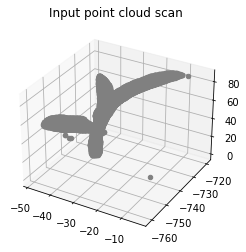

In [5]:
# loading point cloud and computing fpfh
species = 'maize'
day = '03-13'
model_path = './models/{}_svm.joblib'

# loading svm model
clf = joblib.load(model_path.format(species))
path = './data/{}/{}.ply'
P = o3d.io.read_point_cloud(path.format(species, day))
P = P.voxel_down_sample(voxel_size=0.5)

fpfh, xyz = utils.computeHistograms(P)
features = np.column_stack((fpfh, xyz))

fh = plt.figure()
vis.plot_pointcloud(fh, xyz, color='gray')
plt.title('Input point cloud scan')

In [6]:
# stem vs leaf classification
predict = clf.predict(features)
data = np.column_stack((xyz, predict))
stem = data[np.where(data[:, -1] == 0)]
leaf = data[np.where(data[:, -1] == 1)]

C:\Users\Victor\Desktop\4d_plant_registration-master\utils.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(leaves), keep_labels
C:\Users\Victor\Desktop\4d_plant_registration-master\utils.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(leaves), keep_labels


Text(0.5, 0.92, 'Sematic classification of plant organs')

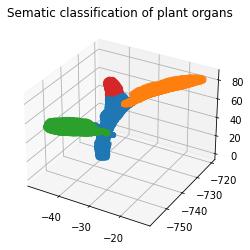

In [7]:
# clustering
dbscan = DBSCAN(min_samples=2, p=0).fit(leaf[:, :-1])
leaves, labels = utils.refineClustering(leaf[:, :-1], dbscan.labels_)
organs = utils.prepare4Skel(stem, leaves) 

fh = plt.figure()
vis.plot_semantic_pointcloud(fh, organs)
plt.title('Sematic classification of plant organs')

Text(0.5, 0.92, 'Skeleton structure of the plant')

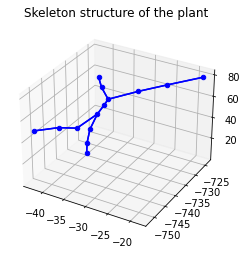

In [8]:
# skeletonization
cwise_skeleton_nodes = som.getSkeleton(organs)
graph = som.getGraph(cwise_skeleton_nodes, xyz)

# convert this graph to skeleton class
S = utils.convert_to_skeleton_class(cwise_skeleton_nodes, graph)

# plot skeleton
fh = plt.figure()
vis.plot_skeleton(fh, S)
plt.title('Skeleton structure of the plant')

## 2. Estimating correspondences between skeleton structures 

Here we compute the correspondences (matches) between skeleton structures of the plant from consecutive scans. This estimation is based on a hidden Markov model formulation which encodes information about the geometric distances and the sematics of the skelton nodes.

In [9]:
# load input data
species = 'maize'
day1 = '03-13'
day2 = '03-14'
skel_path = './data/{}/{}.graph.txt'
pc_path = './data/{}/{}.xyz'

# Day 1
S1 = skel.Skeleton.read_graph(skel_path.format(species, day1))
P1 = pcd.load_pointcloud(pc_path.format(species, day1))

# Day 2
S2 = skel.Skeleton.read_graph(skel_path.format(species, day2))
P2 = pcd.load_pointcloud(pc_path.format(species, day2))

Computing matches.
HMM: Computing Transition and Emission probabilities


Text(0.5, 0.92, 'Skeleton matching results')

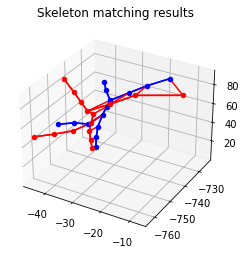

In [10]:


# set parameters for matching step
match_params = {'weight_e': 0.01,
                'match_ends_to_ends': True,
                'use_labels' : False,
                'label_penalty' : 1,
                'debug': False}


# perform matching
corres = skm.skeleton_matching(S1, S2, match_params)
 
# visualize results
fh = plt.figure()
vis.plot_skeleton(fh, S1,'b')
vis.plot_skeleton(fh, S2,'r')
vis.plot_skeleton_correspondences(fh, S1, S2, corres) 
plt.title("Skeleton matching results")

## 3. Estimating the Non-rigid Registration between the skeleton pair

In this step, we estimate the non-rigid registration parameters between the skeleton pair. The non-rigidity is modeled by an affine transformation attached to each node of the source skeleton. Here, we estimate these parameters (12 per node) using a non-linear least squares formulation which encodes the distance between the matching nodes on the two skeletons, closeness of the affine rotation to a true rotation, as well as regularization term which ensures smooth deformation.

Here the blue skeleton is the source skeleton, the red one is the target skeleton and the black skeleton is obtained by applying the estimated
registration params on the source (blue) skeleton.

Computing registration params.
Exiting optimization.
Total error =  [[0.08212197]]


Text(0.5, 0.92, 'Skeleton registration results')

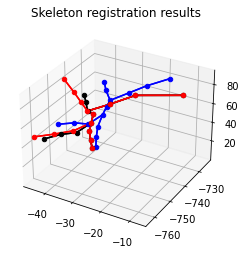

In [11]:
# set parameters for registration
reg_params = {'num_iter': 20,
          'w_rot' : 100,
          'w_reg' : 100,
          'w_corresp' : 1,
          'w_fix' : 1,
          'fix_idx' : [],
          'R_fix' : [np.eye(3)],
          't_fix' : [np.zeros((3,1))],
          'use_robust_kernel' : True,
          'robust_kernel_type' : 'cauchy',
          'robust_kernel_param' : 2,
          'debug' : False}

# call register function
T12 = nrr.register_skeleton(S1, S2, corres, reg_params)

# %% Apply registration params to skeleton
S2_hat = nrr.apply_registration_params_to_skeleton(S1, T12)

# visualize registration results
fh = plt.figure()
vis.plot_skeleton(fh, S1,'b');
vis.plot_skeleton(fh, S2_hat,'k');
vis.plot_skeleton(fh, S2,'r');
vis.plot_skeleton_correspondences(fh, S2_hat, S2, corres)
plt.title("Skeleton registration results")

## 4. Transferring the registration parameters to the complete plant point cloud

Once the registration parameters have been computed between the skeleton nodes, we then transfer these deformation to the entire source point cloud.

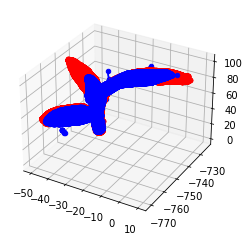

In [12]:
# deform source pointcloud
P1_ds = pcd.downsample_pointcloud(P1, 3)
P2_ds = pcd.downsample_pointcloud(P2, 3)
P1_deformed = pcd.deform_pointcloud(P1_ds, T12, corres, S1, S2)

fh = plt.figure()
vis.plot_skeleton(fh, S1,'b')
vis.plot_skeleton(fh, S2,'r')
vis.plot_pointcloud(fh, P2,'r')
vis.plot_pointcloud(fh, P1_deformed,'b')
vis.plot_skeleton_correspondences(fh, S1, S2, corres, 'g')

## Iterative Registration Procedure

Finally, we perform the skeleton matching and the non-rigid registration of the skeltons in an iterative manner. This improves the registration results by estimating more correspondences between the skeltons by using the latest registration estimates. Note that the iterative process results in a larger number of correspondences as compared to a single skeleton matching step.

-------------------- Global Iteration 0 --------------------------
Computing matches.
HMM: Computing Transition and Emission probabilities


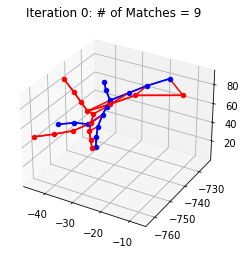

Computing registration params.
Exiting optimization.
Total error =  [[0.08212197]]
Registration error for skeleton nodes =  0.007434900944909445


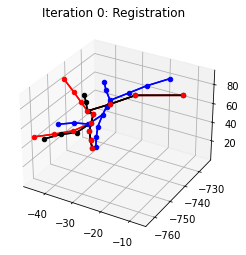

-------------------- Global Iteration 1 --------------------------
Computing matches.
HMM: Computing Transition and Emission probabilities


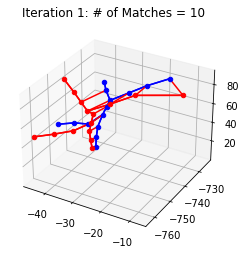

Computing registration params.
Exiting optimization.
Total error =  [[0.08631767]]
Registration error for skeleton nodes =  0.00724716200168198


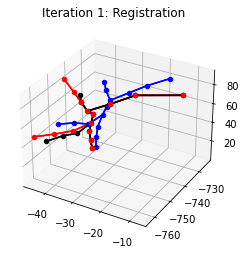

-------------------- Global Iteration 2 --------------------------
Computing matches.
HMM: Computing Transition and Emission probabilities


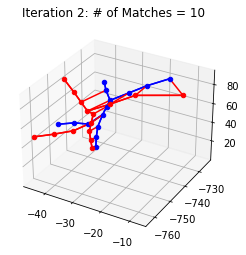

Computing registration params.
Exiting optimization.
Total error =  [[0.08631761]]
Registration error for skeleton nodes =  0.007247161038605532


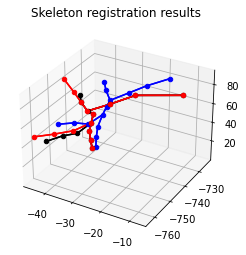

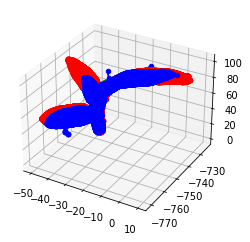

In [13]:
from iterative_registration import iterative_registration

# iterative procedure params
params = {'num_iter' : 5,
          'visualize': True,
          'match_params': match_params,
          'reg_params': reg_params}

# call register function
T12, corres = iterative_registration(S1, S2, params)

# %% Apply registration params to skeleton
S2_hat = nrr.apply_registration_params_to_skeleton(S1, T12)

# %% visualize registration results
fh = plt.figure()
vis.plot_skeleton(fh, S1,'b');
vis.plot_skeleton(fh, S2_hat,'k');
vis.plot_skeleton(fh, S2,'r');
vis.plot_skeleton_correspondences(fh, S2_hat, S2, corres)
plt.title("Skeleton registration results")

# deform complete pointcloud
P1_ds = pcd.downsample_pointcloud(P1, 3)
P2_ds = pcd.downsample_pointcloud(P2, 3)
P1_deformed = pcd.deform_pointcloud(P1_ds, T12, corres, S1, S2)

fh = plt.figure()
vis.plot_skeleton(fh, S1,'b')
vis.plot_skeleton(fh, S2,'r')
vis.plot_pointcloud(fh, P2,'r')
vis.plot_pointcloud(fh, P1_deformed,'b')
vis.plot_skeleton_correspondences(fh, S1, S2, corres, 'g')

## Tomato plant example

Now, we show the overall registration procedure on a pair of tomato scans.

-------------------- Global Iteration 0 --------------------------
Computing matches.
HMM: Computing Transition and Emission probabilities


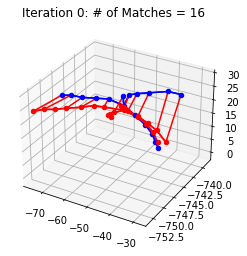

Computing registration params.
Exiting optimization.
Total error =  [[0.05461285]]
Registration error for skeleton nodes =  0.0068298680627958425


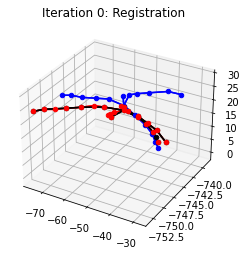

-------------------- Global Iteration 1 --------------------------
Computing matches.
HMM: Computing Transition and Emission probabilities


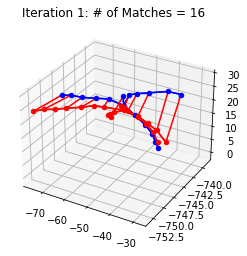

Computing registration params.
Exiting optimization.
Total error =  [[0.05461269]]
Registration error for skeleton nodes =  0.006829841522607332


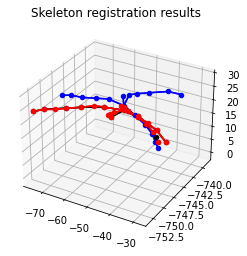

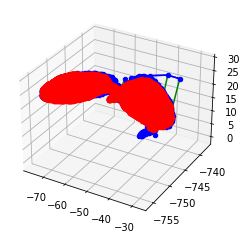

In [14]:
# load input data
species = 'tomato'
day1 = '03-05'
day2 = '03-06'
skel_path = './data/{}/{}.graph.txt'
pc_path = './data/{}/{}.xyz'

# Day 1
S1 = skel.Skeleton.read_graph(skel_path.format(species, day1))
P1 = pcd.load_pointcloud(pc_path.format(species, day1))

# Day 2
S2 = skel.Skeleton.read_graph(skel_path.format(species, day2))
P2 = pcd.load_pointcloud(pc_path.format(species, day2))

# iterative procedure params
match_params = {'weight_e': 0.01,
                'match_ends_to_ends': True,
                'use_labels' : False,
                'label_penalty' : 1,
                'debug': False}

reg_params = {'num_iter': 20,
          'w_rot' : 100,
          'w_reg' : 100,
          'w_corresp' : 1,
          'w_fix' : 1,
          'fix_idx' : [],
          'R_fix' : [np.eye(3)],
          't_fix' : [np.zeros((3,1))],
          'use_robust_kernel' : True,
          'robust_kernel_type' : 'cauchy',
          'robust_kernel_param' : 2,
          'debug' : False}

params = {'num_iter' : 5,
          'visualize': True,
          'match_params': match_params,
          'reg_params': reg_params}

# call iterative registration function
T12, corres = iterative_registration(S1, S2, params)

# Apply registration params to skeleton
S2_hat = nrr.apply_registration_params_to_skeleton(S1, T12)

# %% visualize registration results
fh = plt.figure()
vis.plot_skeleton(fh, S1,'b');
vis.plot_skeleton(fh, S2_hat,'k');
vis.plot_skeleton(fh, S2,'r');
vis.plot_skeleton_correspondences(fh, S2_hat, S2, corres)
plt.title("Skeleton registration results")

# deform complete pointcloud
P1_ds = pcd.downsample_pointcloud(P1, 3)
P2_ds = pcd.downsample_pointcloud(P2, 3)
P1_deformed = pcd.deform_pointcloud(P1_ds, T12, corres, S1, S2)

fh = plt.figure()
vis.plot_skeleton(fh, S1,'b')
vis.plot_skeleton(fh, S2,'r')
vis.plot_pointcloud(fh, P2,'r')
vis.plot_pointcloud(fh, P1_deformed,'b')
vis.plot_skeleton_correspondences(fh, S1, S2, corres, 'g')